In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd

import os
import pickle as pkl
from os.path import join as oj
from io import StringIO
from IPython.display import Image
import warnings

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import pydotplus
#from dtreeviz.trees import dtreeviz - not loaded...

import sys
sys.path.append('../../../../')
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn.graph import barplot

from sklearn.ensemble import AdaBoostClassifier
from logitboost import LogitBoost
from sklearn.metrics import roc_auc_score

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output
data_path = '../../../../data/' # path to raw csv - change to processed...


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting font sizes and properties
TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180

# Height and width per row and column of subplots
FIG_HEIGHT = 20
FIG_WIDTH = 18
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("colorblind")

/Users/aprasad/Library/Python/3.9/lib/python/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
df = Dataset().clean_data(data_path = data_path)
df = Dataset().preprocess_data(df)
df_train, df_tune, _ = Dataset().split_data(df)
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values
processed_feats = df_train.keys().values.tolist()
feature_names = list(X_train)


def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

Reading the raw CSVs... ['TBI PUD 10-08-2013.csv', 'TBI PUD Imaging.csv', 'TBI PUD Neuro.csv']


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.47it/s]
/usr/local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
simple_var_list = ['InjuryMech_Assault',
       'InjuryMech_Bicyclist struck by automobile',
       'InjuryMech_Bike collision/fall', 'InjuryMech_Fall down stairs',
       'InjuryMech_Fall from an elevation',
       'InjuryMech_Fall to ground standing/walking/running',
       'InjuryMech_Motor vehicle collision',
       'InjuryMech_Object struck head - accidental',
       'InjuryMech_Other mechanism', 'InjuryMech_Other wheeled crash',
       'InjuryMech_Pedestrian struck by moving vehicle', 'InjuryMech_Sports',
       'InjuryMech_Walked/ran into stationary object',
       'High_impact_InjSev_High', 'High_impact_InjSev_Low',
       'High_impact_InjSev_Moderate', 'High_impact_InjSev_No', 'Amnesia_verb_No', 
       'Amnesia_verb_Pre/Non-verbal', 'Amnesia_verb_Yes',
       'LOCSeparate_No', 'LOCSeparate_Suspected', 'LOCSeparate_Yes', 
       'Seiz', 'ActNorm', 'HA_verb_No', 'HA_verb_Pre/Non-verbal', 'HA_verb_Yes',
        'Vomit', 'Intubated', 'Paralyzed', 'Sedated', 'AMS', 'SFxPalp_No', 'SFxPalp_Unclear', 'SFxPalp_Yes',
       'FontBulg', 'Hema', 'Clav', 'NeuroD', 'OSI', 'Drugs', 'AgeTwoPlus', 'Gender', 'outcome']


df_simp = df[simple_var_list + ["GCSGroup"]]
df_simp = df_simp.loc[df_simp["GCSGroup"] != 1]
df_simp = df_simp.drop(columns=["GCSGroup"])
df_simp_train, df_simp_tune, _ = Dataset().split_data(df_simp)
X_simp_train = df_simp_train.drop(columns=outcome_def)
y_simp_train = df_simp_train[outcome_def].values
X_simp_tune = df_simp_tune.drop(columns=outcome_def)
y_simp_tune = df_simp_tune[outcome_def].values

In [4]:
# SANITY CHECK
df_simp.iloc[0, :]

InjuryMech_Assault                                    1
InjuryMech_Bicyclist struck by automobile             0
InjuryMech_Bike collision/fall                        0
InjuryMech_Fall down stairs                           0
InjuryMech_Fall from an elevation                     0
InjuryMech_Fall to ground standing/walking/running    0
InjuryMech_Motor vehicle collision                    0
InjuryMech_Object struck head - accidental            0
InjuryMech_Other mechanism                            0
InjuryMech_Other wheeled crash                        0
InjuryMech_Pedestrian struck by moving vehicle        0
InjuryMech_Sports                                     0
InjuryMech_Walked/ran into stationary object          0
High_impact_InjSev_High                               0
High_impact_InjSev_Low                                0
High_impact_InjSev_Moderate                           1
High_impact_InjSev_No                                 0
Amnesia_verb_No                                 

# Useful Functions and Parameters

In [5]:
def fit_eval_boosted(model, X_train, y_train, X_val, y_val, title_str):
    # Fit model
    model.fit(X_train, y_train)
    
    # Find accuracies on train/val sets
    # This takes ~2 minutes to run
    auc_train = []
    acc_train = []
    auc_val = []
    acc_val = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        train_pred = list(model.staged_predict_proba(X_train))
        val_pred = list(model.staged_predict_proba(X_val))

        for tp in train_pred:
            auc_train.append(roc_auc_score(y_train, tp[:, 1]))
            acc_train.append((y_train == tp.argmax(axis=1)).mean())
        for vp in val_pred:
            auc_val.append(roc_auc_score(y_val, vp[:, 1]))
            acc_val.append((y_val == vp.argmax(axis=1)).mean())

    # Plot ACC/AUC as function of number of weak learners
    plt.figure()
    plt.suptitle(title_str + " Performance", y=1.02)

    plt.subplot(1, 2, 1)
    plt.plot(acc_train, label="Train ACC", color=color_list[0])
    plt.plot(auc_train, label="Train AUC", color=color_list[1])
    plt.xlabel("Number of Weak Learners")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc_val, label="Val ACC", color=color_list[2])
    plt.plot(auc_val, label="Val AUC", color=color_list[3])
    plt.xlabel("Number of Weak Learners")
    plt.legend()

    plt.tight_layout()
    
    # Plot Feature Importances
    barplot(pd.Series(dict(zip(simple_var_list[:-1], 
                           model.feature_importances_))).sort_values(ascending=False),
        False, title_str + " Feature Importance (Gini)"
       )
    
    return (model, {"acc_train" : acc_train, "auc_train" : auc_train, "acc_val" : acc_val, "auc_val" : auc_val})

    

# LogitBoost

/Users/aprasad/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


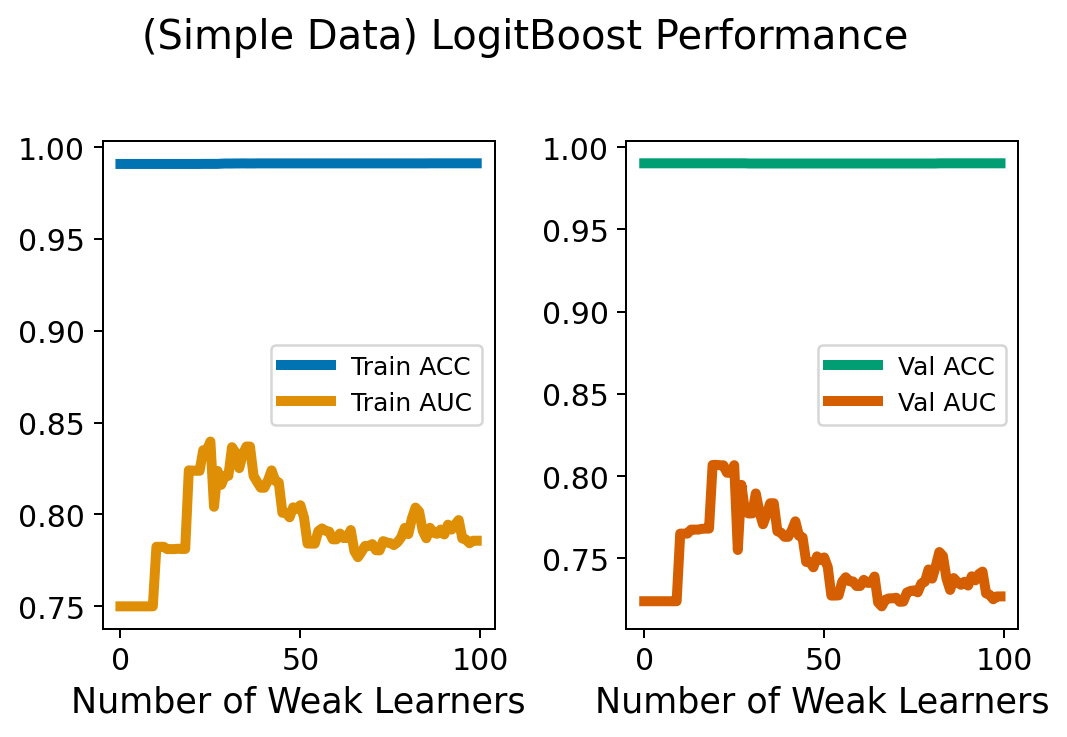

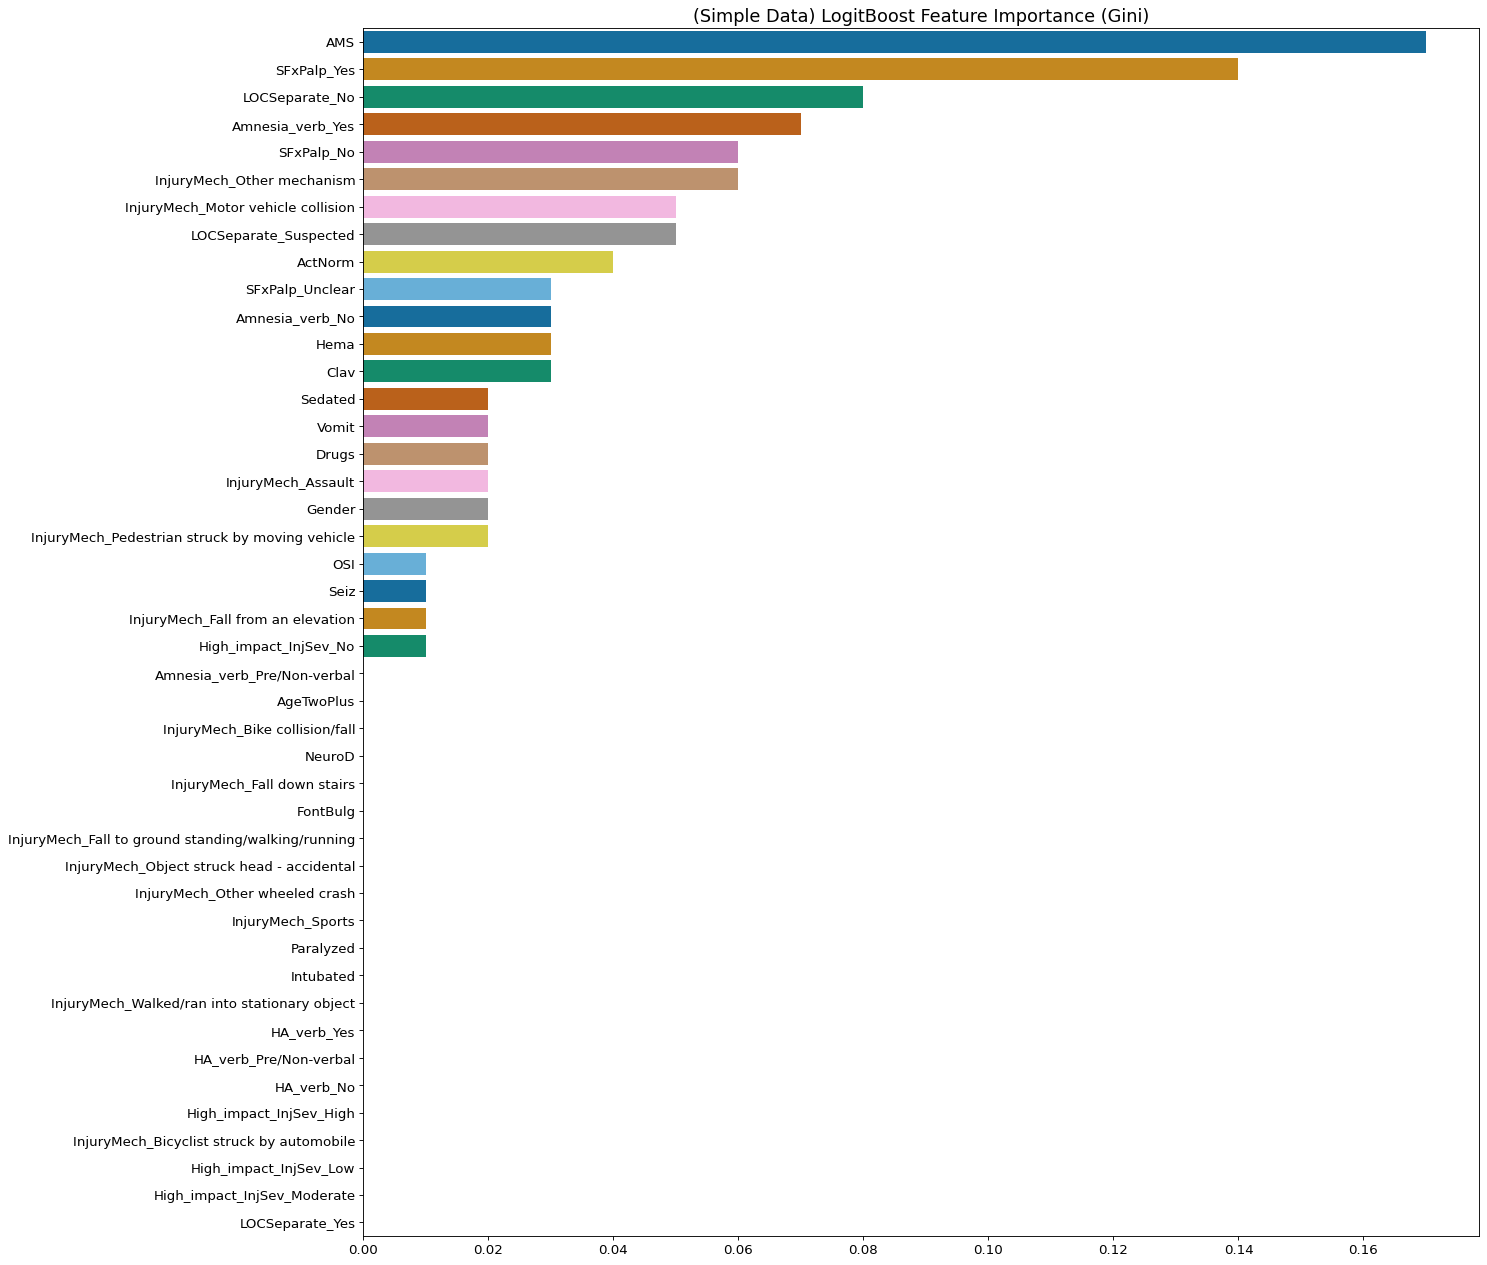

In [6]:
# Fit LogitBoost model
# Note that n is the number of weak learners (we could in principle tune this)
lboost = LogitBoost(n_estimators=100, random_state=0)
lboost, lboost_perf = fit_eval_boosted(lboost, X_simp_train, y_simp_train, X_simp_tune, y_simp_tune, "(Simple Data) LogitBoost")

/Users/aprasad/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


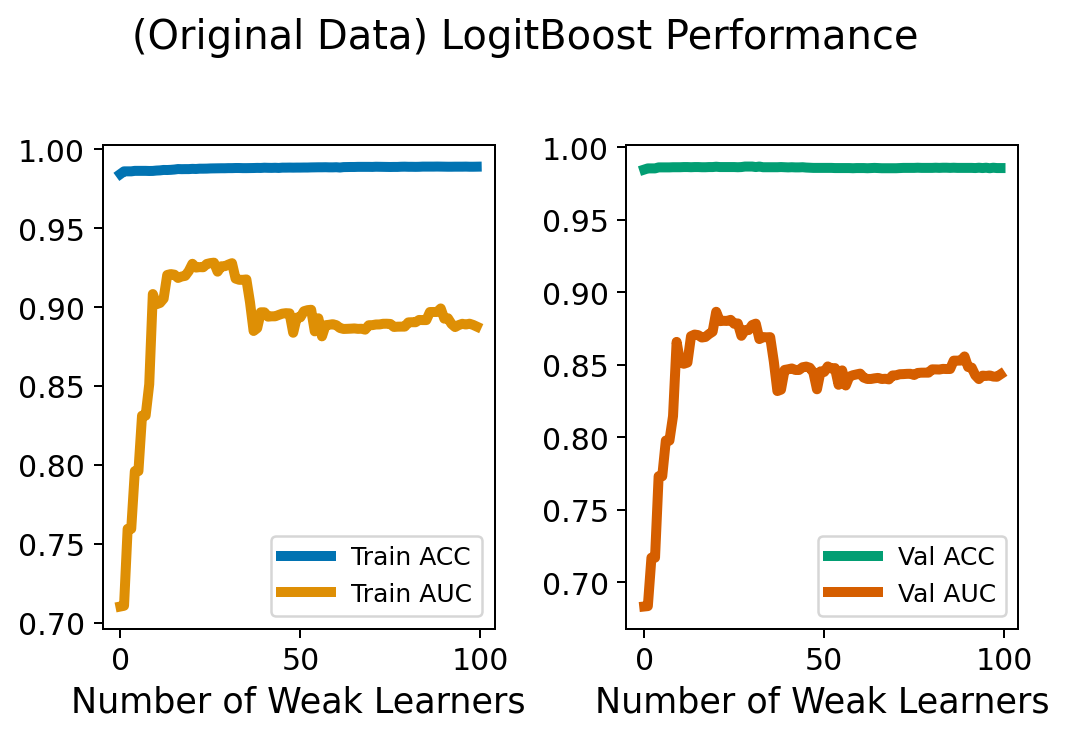

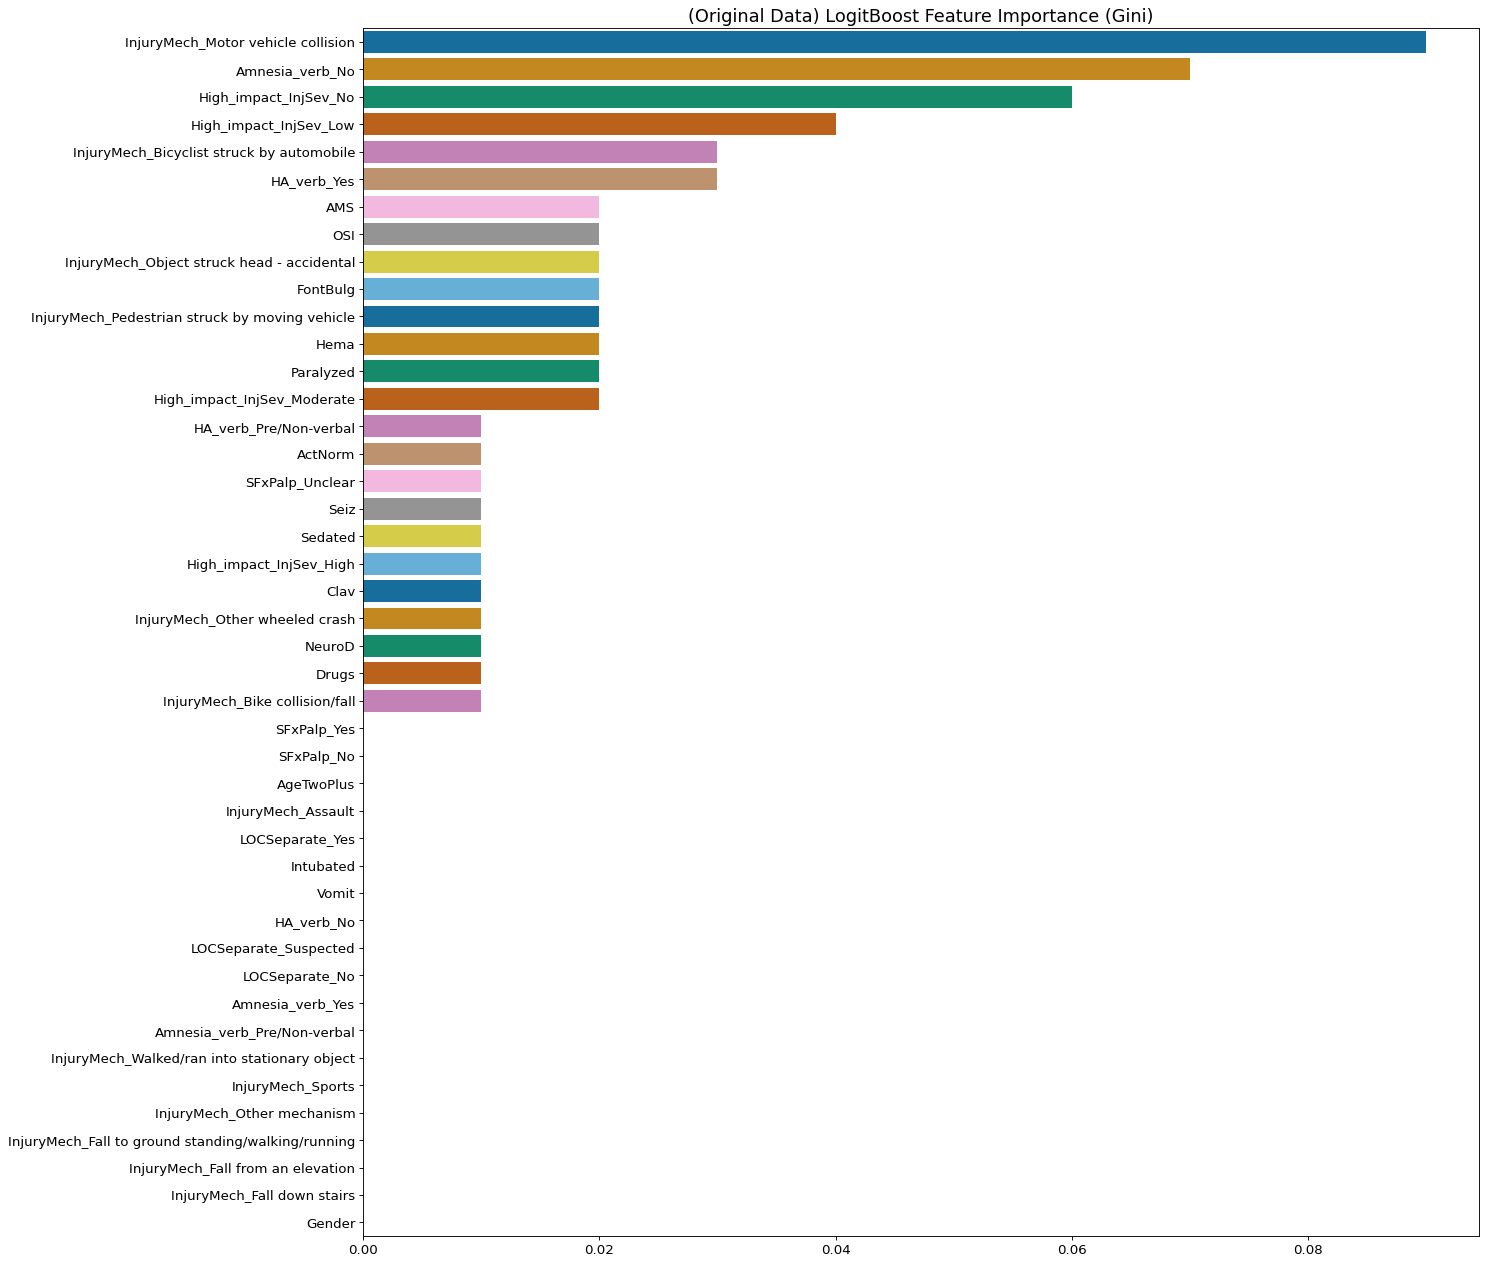

In [7]:
# Fit LogitBoost model
# Note that n is the number of weak learners (we could in principle tune this)
lboost_og = LogitBoost(n_estimators=100, random_state=0)
lboost_og, lboost_og_perf = fit_eval_boosted(lboost_og, X_train, y_train, X_tune, y_tune, "(Original Data) LogitBoost")

# AdaBoost

/Users/aprasad/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


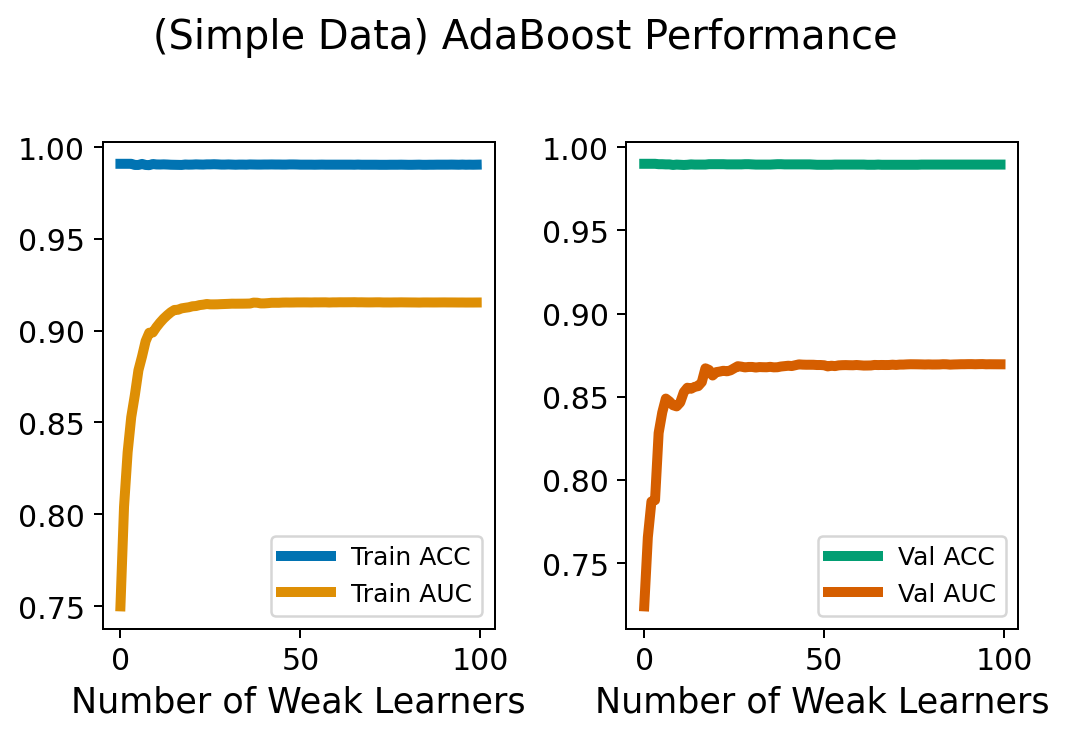

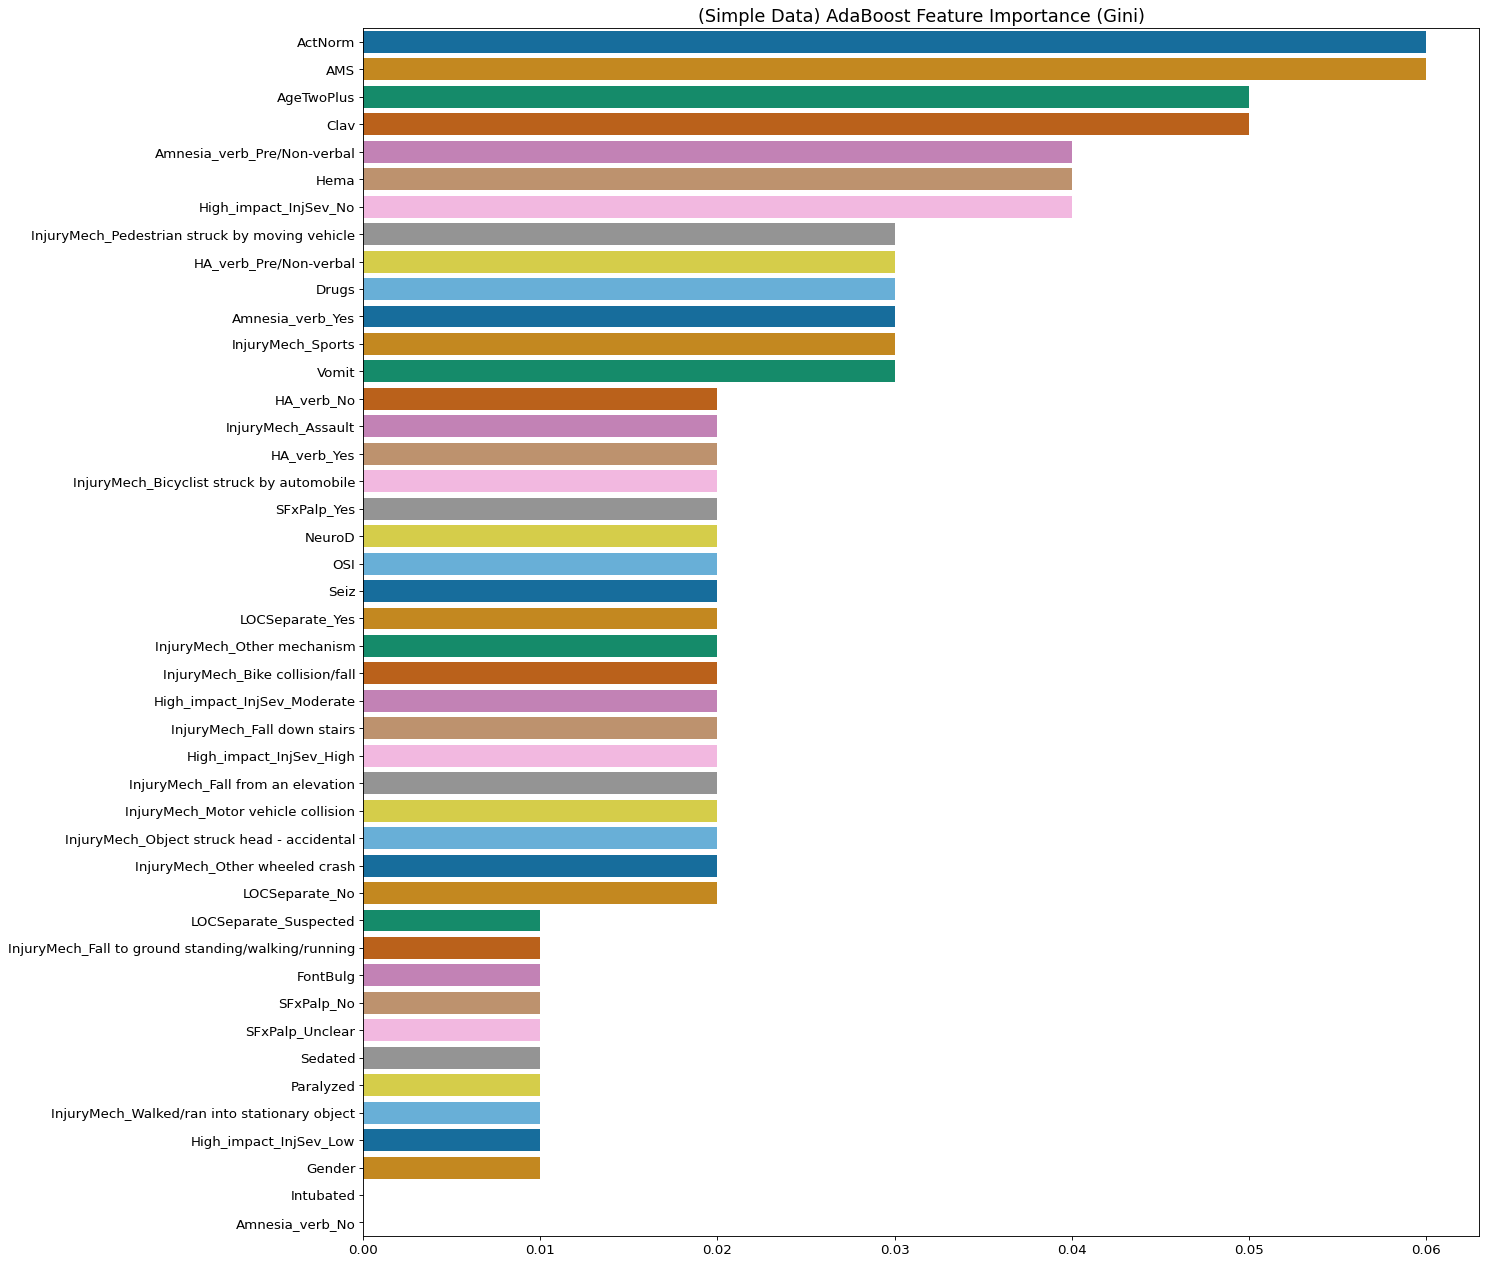

In [8]:
# Fit LogitBoost model
# Note that n is the number of weak learners (we could in principle tune this)
aboost = AdaBoostClassifier(n_estimators=100, random_state=0)
aboost, aboost_perf = fit_eval_boosted(aboost, X_simp_train, y_simp_train, X_simp_tune, y_simp_tune, "(Simple Data) AdaBoost")

/Users/aprasad/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


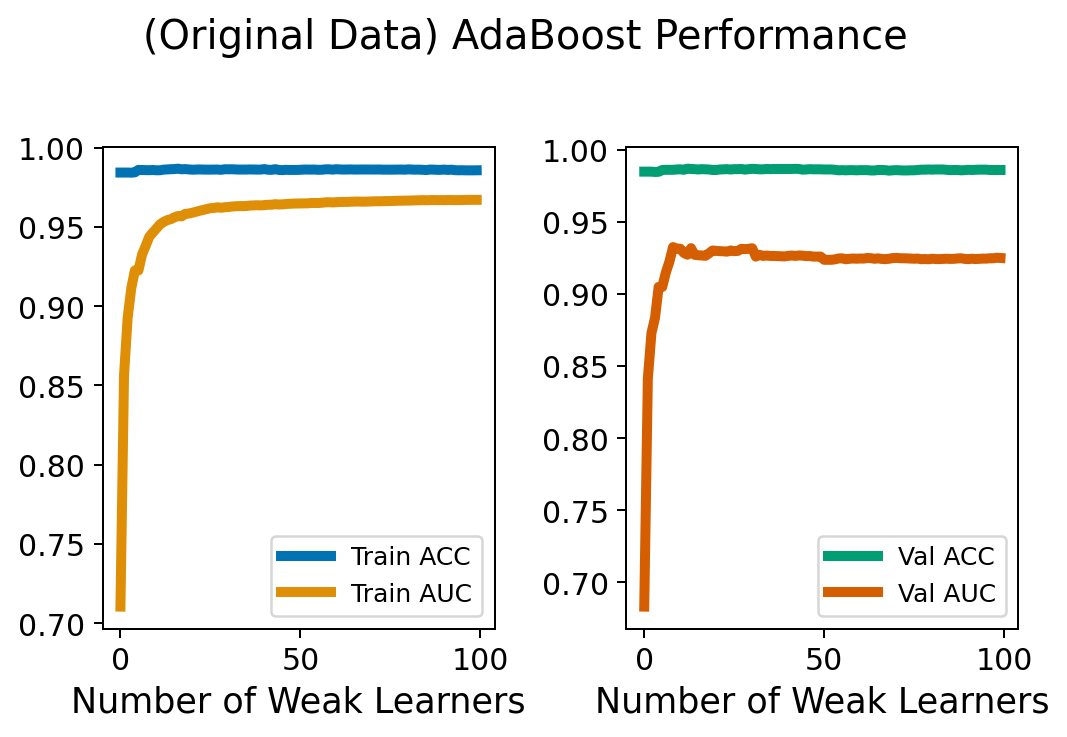

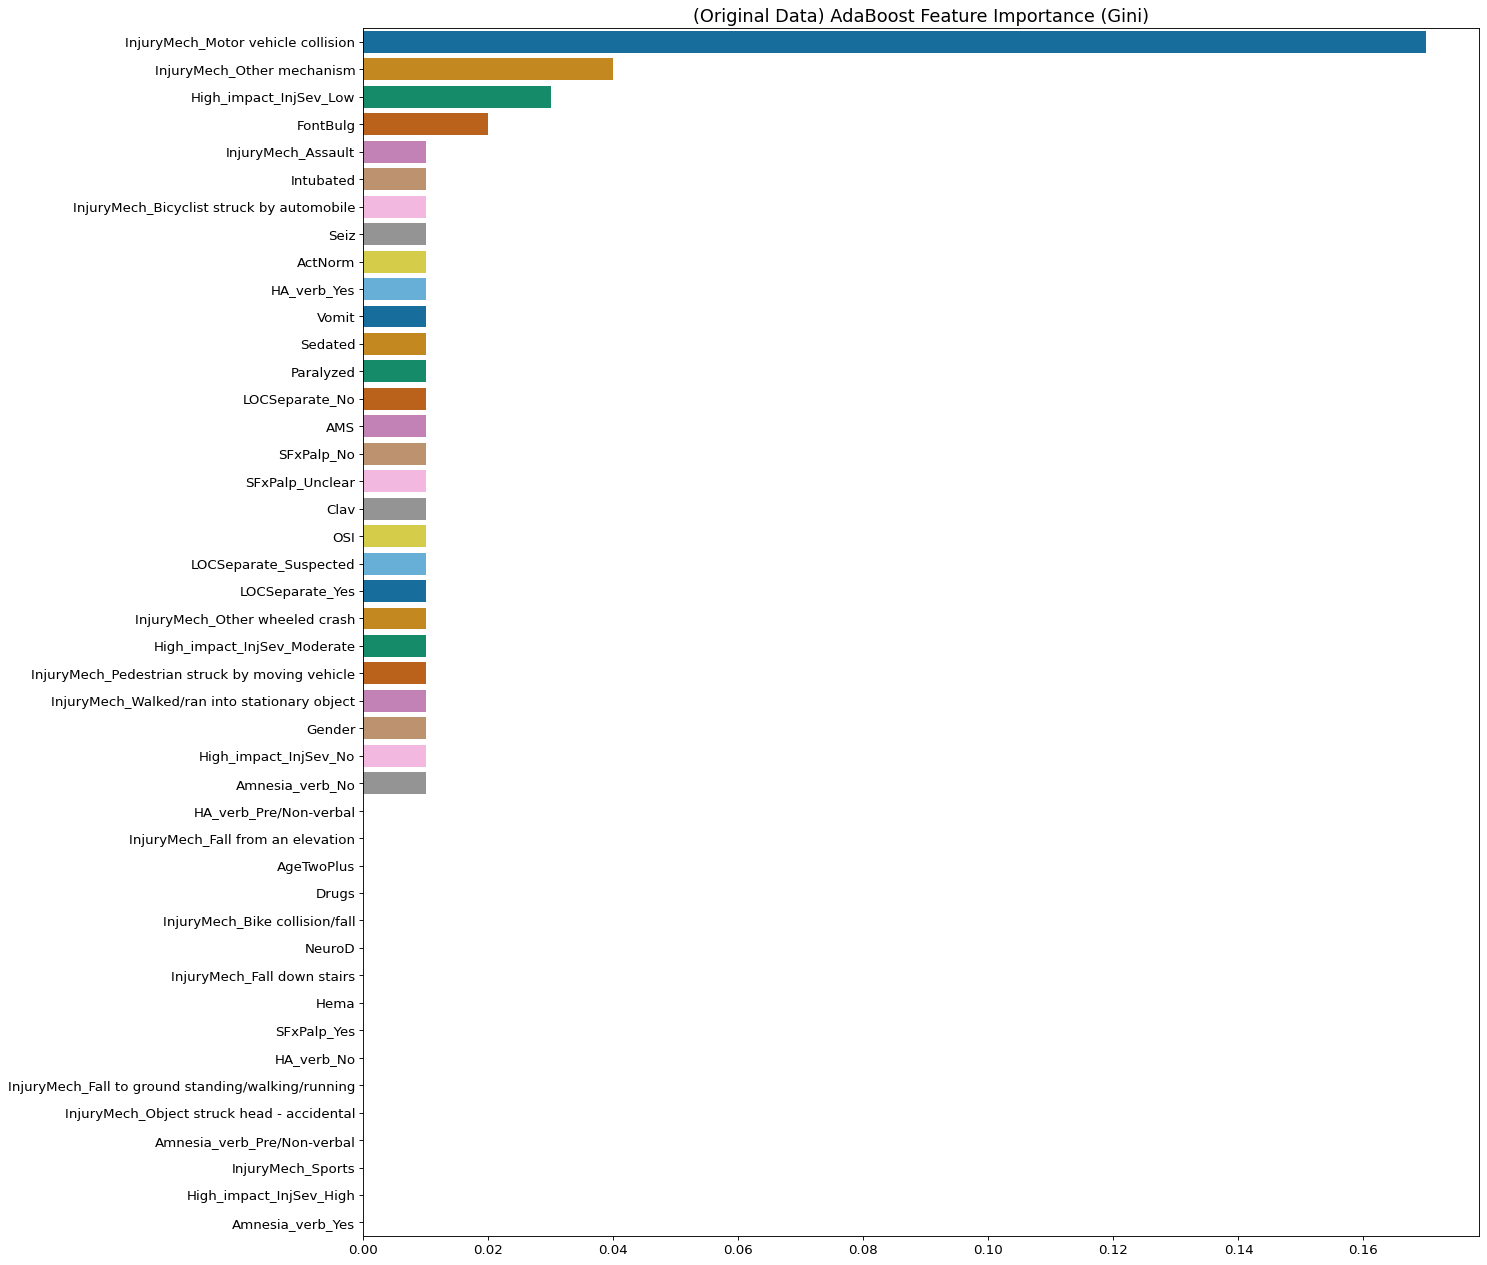

In [9]:
# Fit LogitBoost model
# Note that n is the number of weak learners (we could in principle tune this)
aboost_og = AdaBoostClassifier(n_estimators=100, random_state=0)
aboost_og, aboost_og_perf = fit_eval_boosted(aboost_og, X_train, y_train, X_tune, y_tune, "(Original Data) AdaBoost")